# Settings

In [ ]:
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/data_loading.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/scoring.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_methods.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_functions.R")

library(viridis)
library(tidytext)

Sys.setlocale("LC_TIME", "C")
Sys.setlocale("LC_ALL", "C")

In [2]:
theme_set(theme_gray(base_size = 18))

In [3]:
end_date = "2021-06-19"

In [4]:
scores <- load_scores(paste0("scores/", end_date, "_scores.csv"), long_format=TRUE) %>%
  filter(!model %in% c("CU-scenario_high", "CU-scenario_mid", "CU-scenario_low", "CU-nochange", "USC-SI_kJalpha")) %>%
  filter(location != "US")

# Mean WIS

The mean WIS is computed across all states and dates. The gray area shows the baseline performance. 

In [5]:
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) parse(text=gsub(reg, "", x)), ...)
}

In [6]:
options(repr.plot.width=15, repr.plot.height=28, repr.plot.res = 300)

In [7]:
base_df <- subset(scores, model=="COVIDhub-baseline" & score == "wis")  %>% 
  group_by(target)  %>% 
  summarize(mean_wis = mean(value))

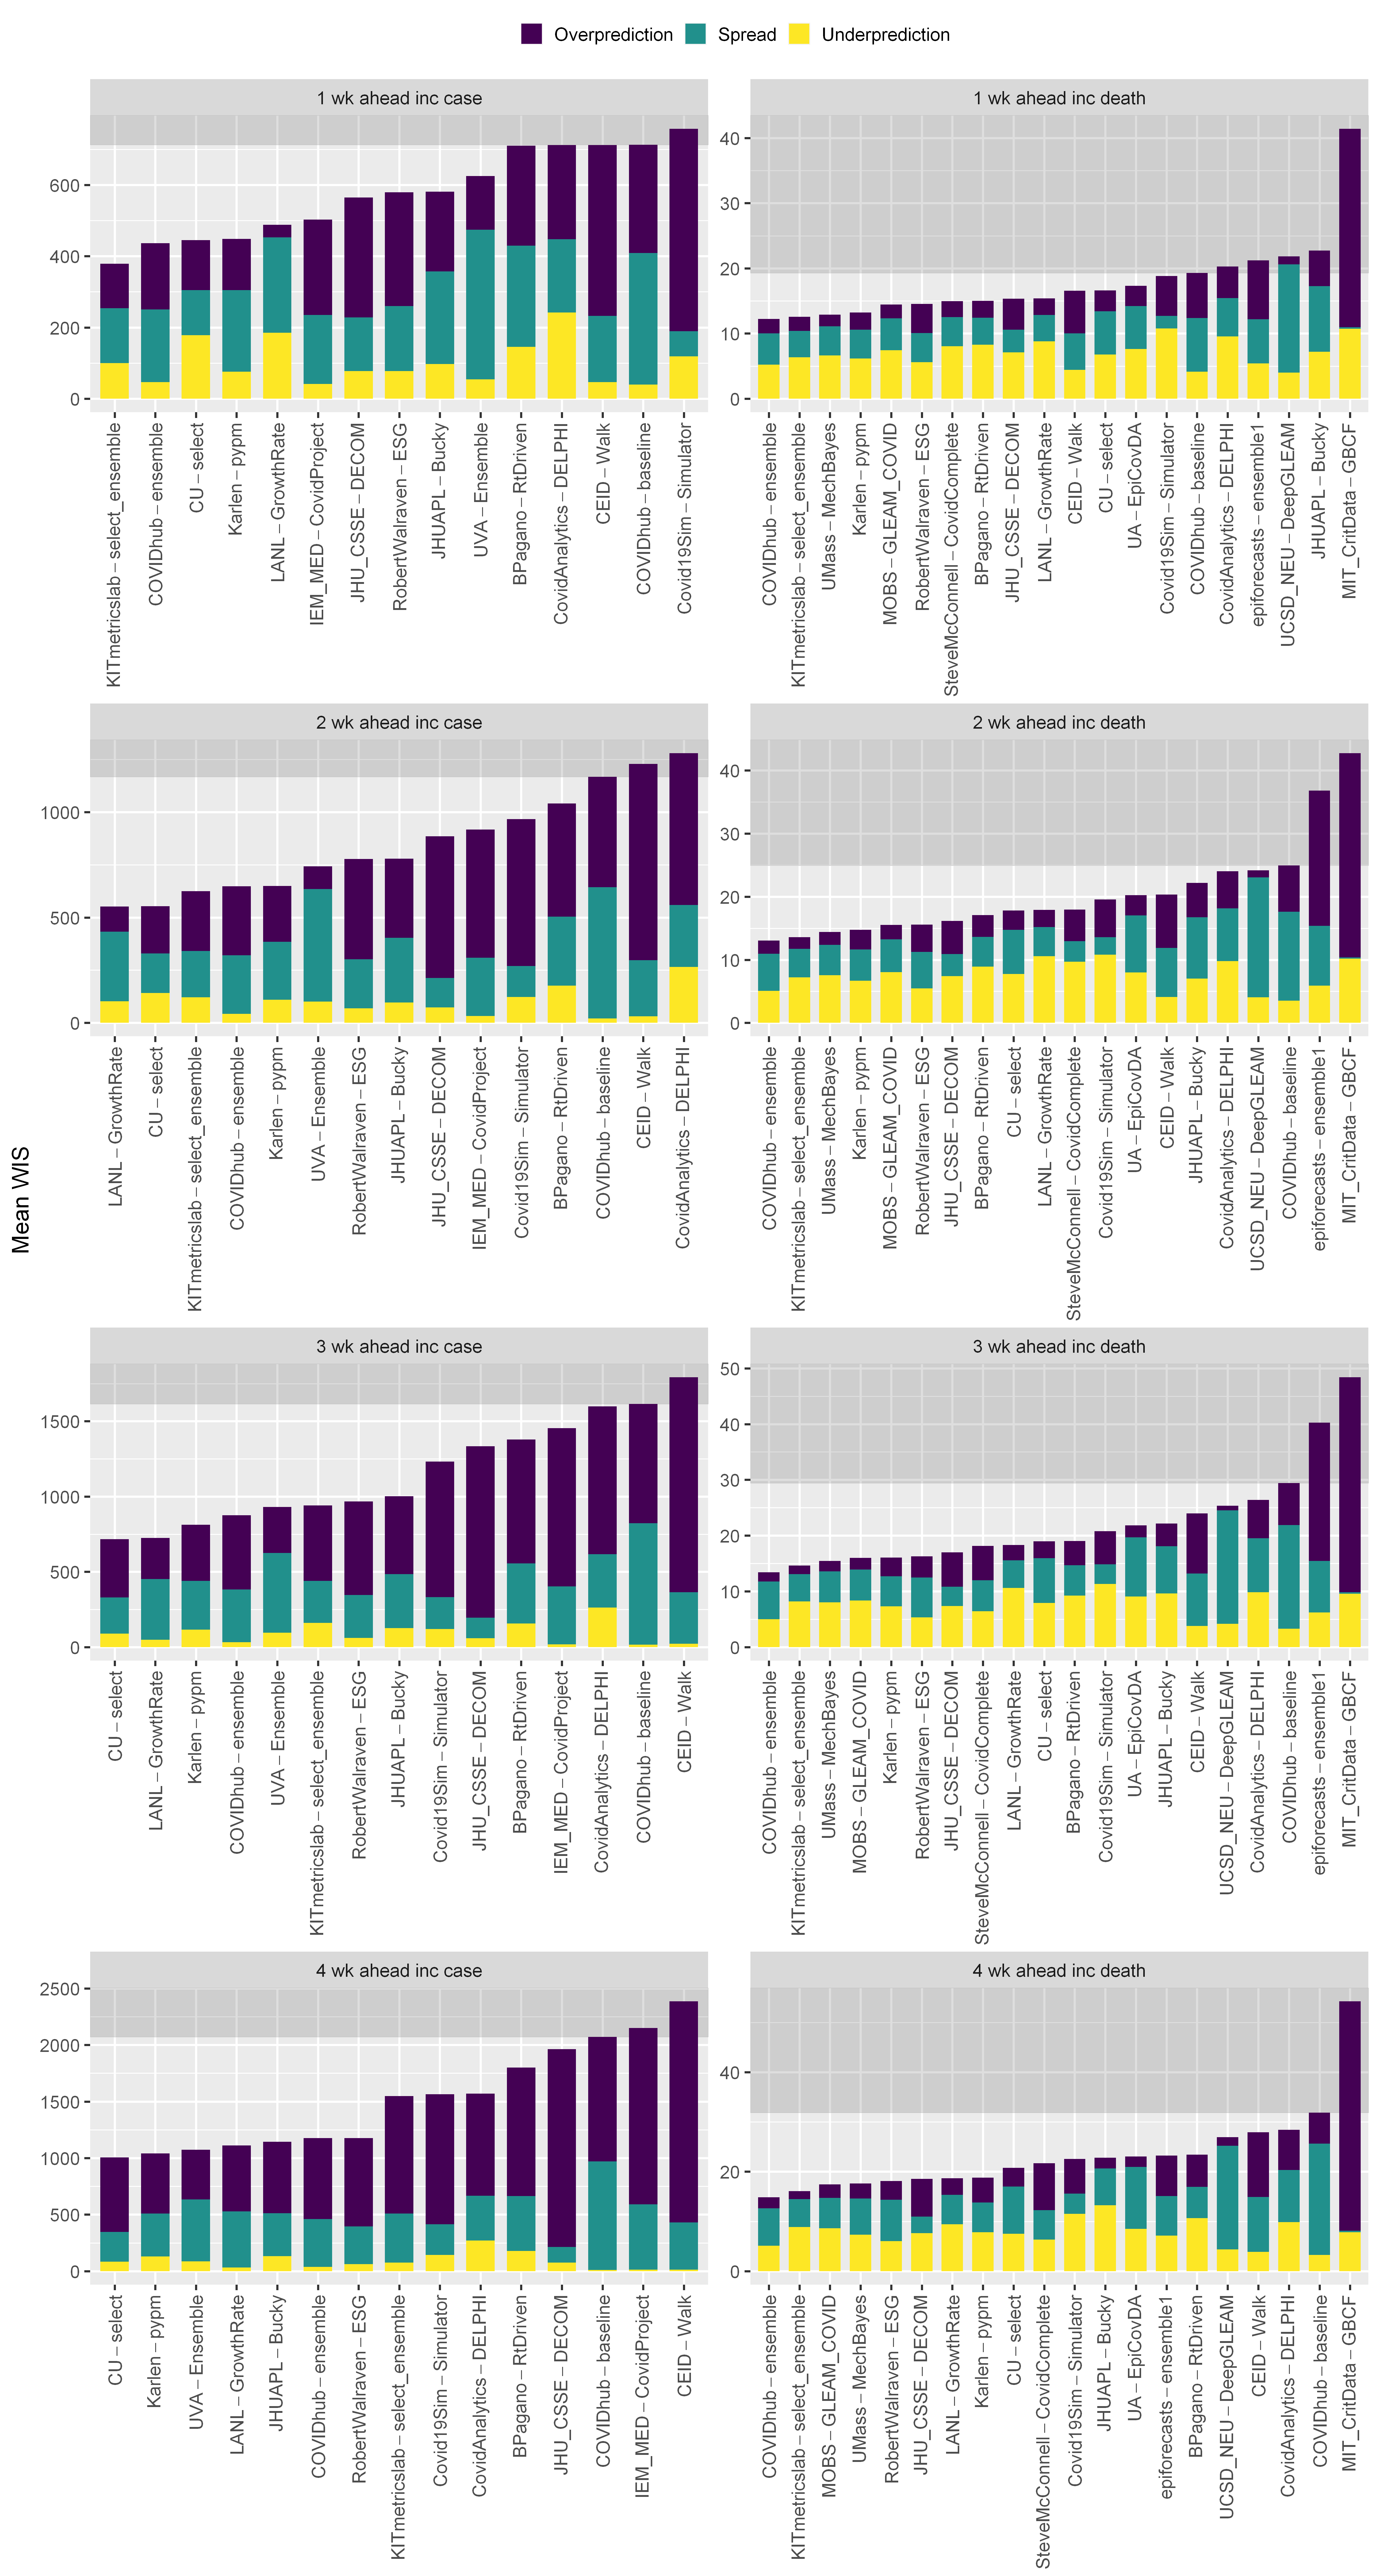

In [8]:
ggplot(subset(scores, score %in% c("wgt_pen_l", "wgt_iw", "wgt_pen_u")), 
       aes(x=reorder_within(model, value, target), y=value,
           fill=factor(score, levels=c("wgt_pen_l", "wgt_iw", "wgt_pen_u")))) +
  geom_rect(data=base_df, 
              aes(xmin=-Inf, xmax=Inf, x=NULL, ymin=mean_wis, ymax=Inf),
             size=0, color="gray", alpha=0.2, inherit.aes = FALSE) +
  geom_bar(position="stack", stat="summary", fun=mean, width=0.7) +
  scale_x_reordered() +
  facet_wrap("target", scales="free", drop=TRUE, ncol=2) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position = "top") +
  scale_fill_viridis(discrete=TRUE, name = NULL,
                     labels = c("Overprediction", "Spread", "Underprediction"))+
  labs(x = NULL,
       y = "Mean WIS")

# Mean WIS over time

The mean WIS is computed at each target end date across all states. The gray area shows the baseline performance. The ensemble methods are highlighted with thicker lines (the greenish thick line is the KITmetricslab-select_ensemble).

In [9]:
wis_by_date <- scores %>%
  filter(score == "wis") %>%
  group_by(target, model, target_end_date) %>%
  summarize(mean_WIS = mean(value))

In [10]:
wis_by_date <- wis_by_date %>%
  mutate(highlight = (model=="KITmetricslab-select_ensemble" | model=="COVIDhub-ensemble"))

In [11]:
options(repr.plot.width=15, repr.plot.height=24, repr.plot.res = 300)

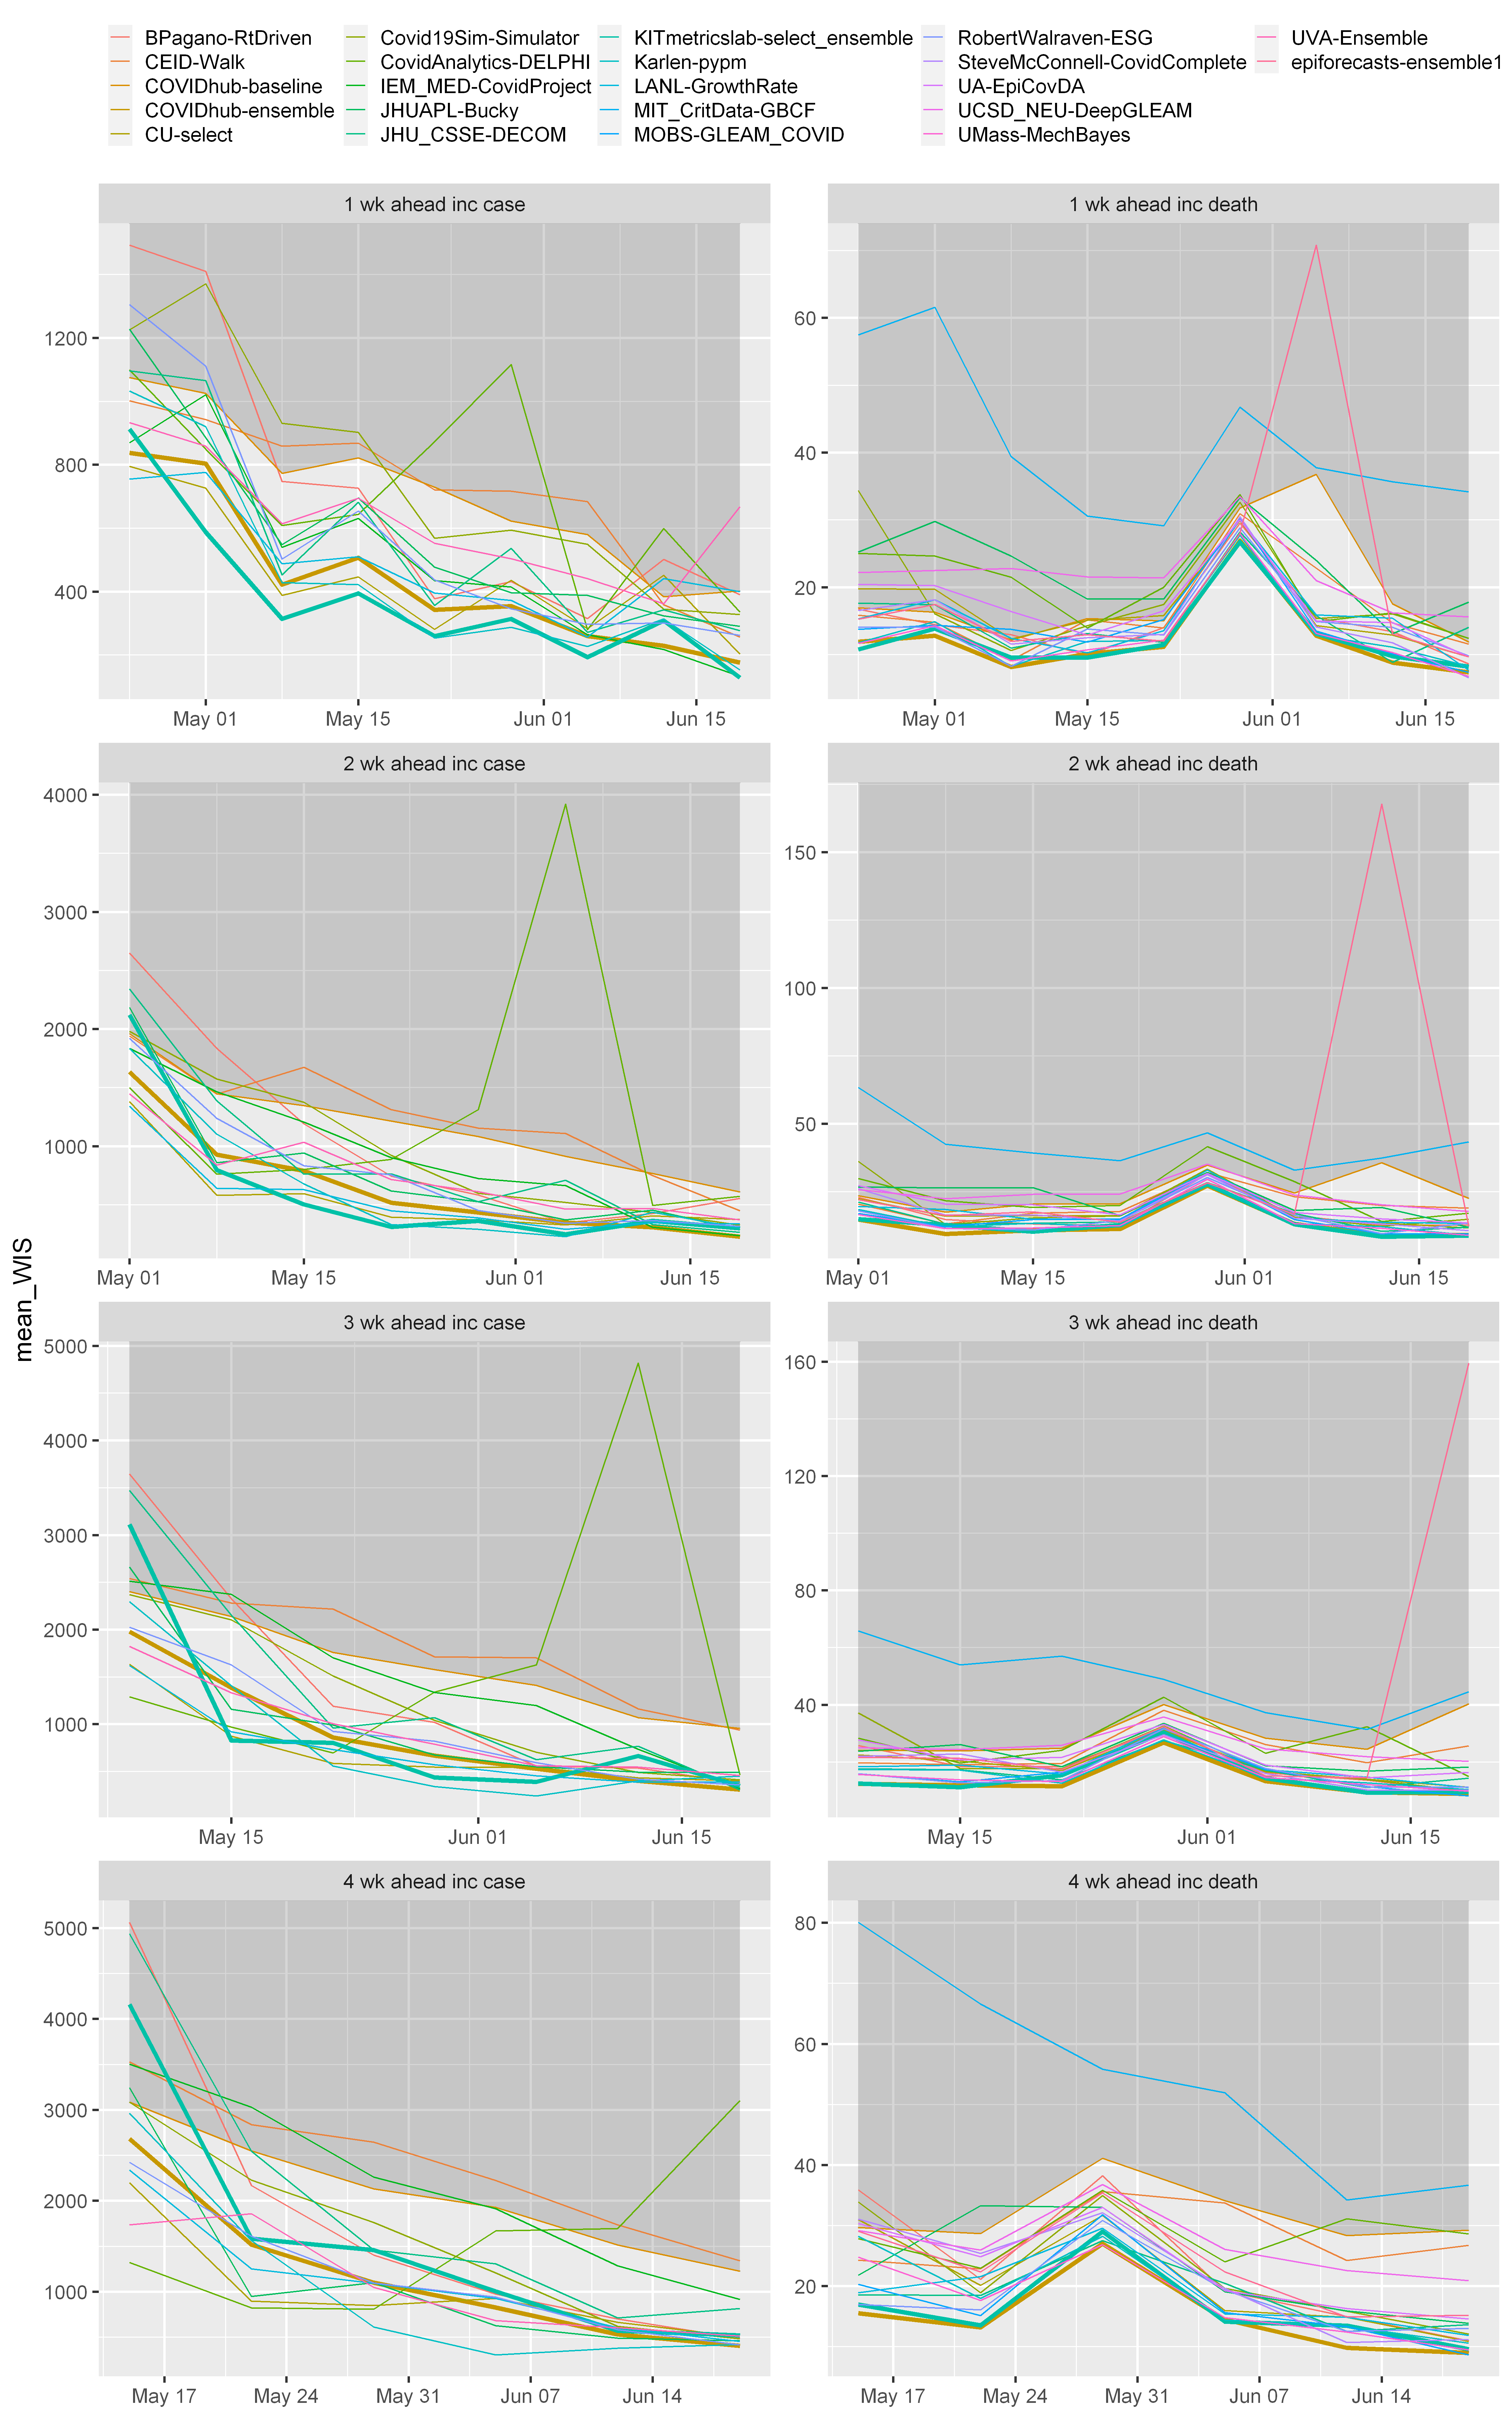

In [12]:
ggplot(wis_by_date, aes(x=target_end_date, y=mean_WIS, group=model)) +
  geom_ribbon(data = subset(wis_by_date,  model == "COVIDhub-baseline"), aes(x=target_end_date, ymin=mean_WIS, ymax=Inf),
             color="gray", alpha=0.2) + 
  geom_line(aes(color=model, size=highlight)) +
  facet_wrap("target", scales="free", ncol=2) +
  scale_size_manual(values = c("TRUE" = 1.5, "FALSE" = 0.5), guide = 'none') +
  xlab(NULL) +
  theme(legend.position = "top", legend.title=element_blank())

# Rank boxplots

The rank is computed for each location (at each date).

In [13]:
df_rank <- scores  %>% 
  filter(score == "wis") %>%
  group_by(target, target_end_date, location, model) %>%
  summarize(meanWIS = mean(value)) %>%
  group_by(target, target_end_date, location) %>%
  arrange(model, meanWIS) %>% 
  mutate(rank=rank(meanWIS)) %>%
  arrange(target_end_date)

df_rank <- df_rank %>%
  group_by(model) %>%
  mutate(meanRank=mean(rank))

In [14]:
df_rank$type <- "Individual Model"

df_rank[df_rank$model == "KITmetricslab-select_ensemble" |
        df_rank$model == "COVIDhub-ensemble", ]$type <- "Ensemble"

df_rank[df_rank$model == "COVIDhub-baseline", ]$type <- "Baseline"

In [15]:
options(repr.plot.width=16, repr.plot.height=28, repr.plot.res = 300)

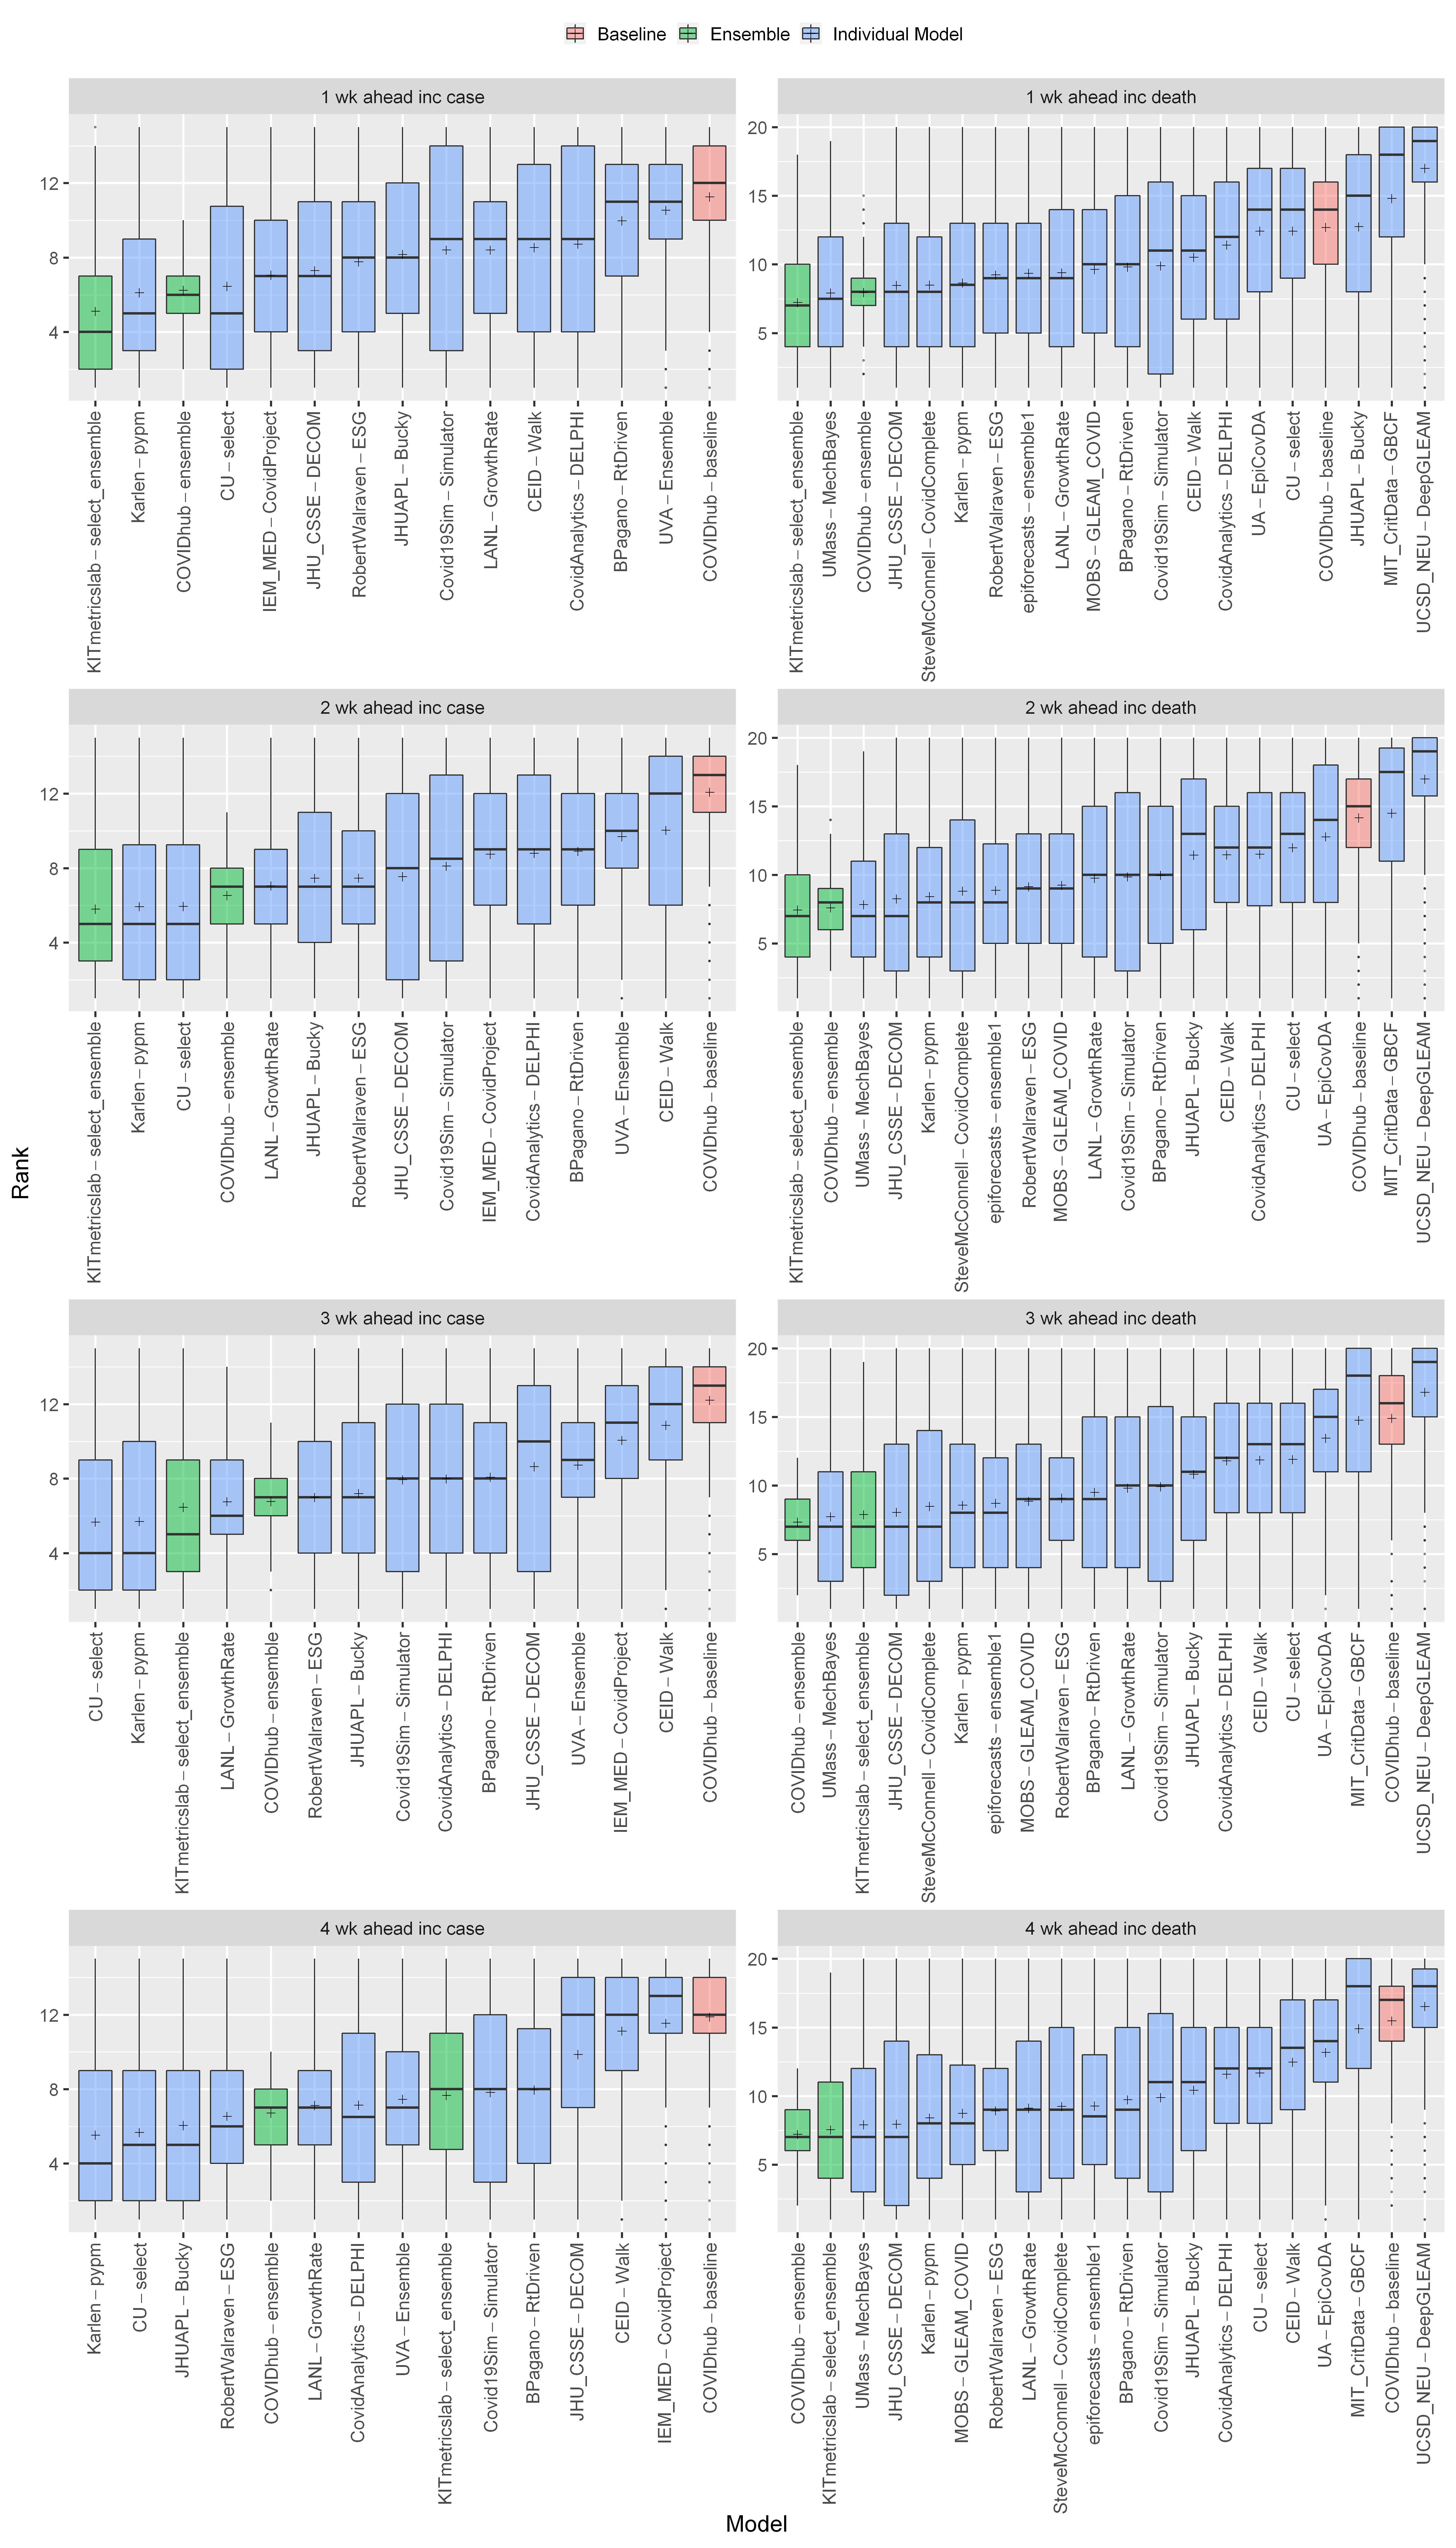

In [16]:
ggplot(df_rank, aes(x=reorder_within(model, rank, target), fill=type, y=rank)) + 
  scale_x_reordered() +
  facet_wrap("target", ncol=2, scales="free") +
  geom_boxplot(alpha=0.5, outlier.size = 0.6) +
  stat_summary(fun=mean, geom="point", shape=3, size=2) +
  xlab("Model") +
  ylab("Rank") +
  theme_gray(base_size=18) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position="top", legend.title=element_blank()) 

# Coverage Plots

In [17]:
df <- read_csv("evaluation/2021-06-19_df_processed.csv", col_types = cols())

In [18]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [19]:
plot_coverage <- function(t="death", models=c("KITmetricslab-select_ensemble", "COVIDhub-ensemble", "COVIDhub-baseline")){
    df_temp <- df %>%
    filter(str_detect(target, t) &
          model %in% models)
    df_temp$l <- df_temp$truth < floor(df_temp$value)
    df_temp$u <- df_temp$truth <= floor(df_temp$value)

    df_temp <- df_temp %>%
        group_by(target, model, quantile) %>%
        summarize(l = mean(l), u=mean(u))

    ggplot(df_temp) +
        facet_grid(rows=vars(target), cols=vars(model)) +
        geom_segment(aes(x=0,xend=1,y=0,yend=1), linetype="dashed", colour="grey70")+
        geom_errorbar(aes(x=quantile, ymin=l, ymax=u), width=0.05, size=0.5,
                      data=df_temp, colour="black") +
        scale_x_continuous(breaks = c(0, 0.25, 0.5, 0.75, 1),
                           labels = function(x) ifelse(x == 0, "0", x)) +
        scale_y_continuous(labels = function(y) ifelse(y == 0, "0", y)) +
        xlab('Quantile') +
        ylab('') +
        labs(title=paste0(str_to_title(t), "s"))
}

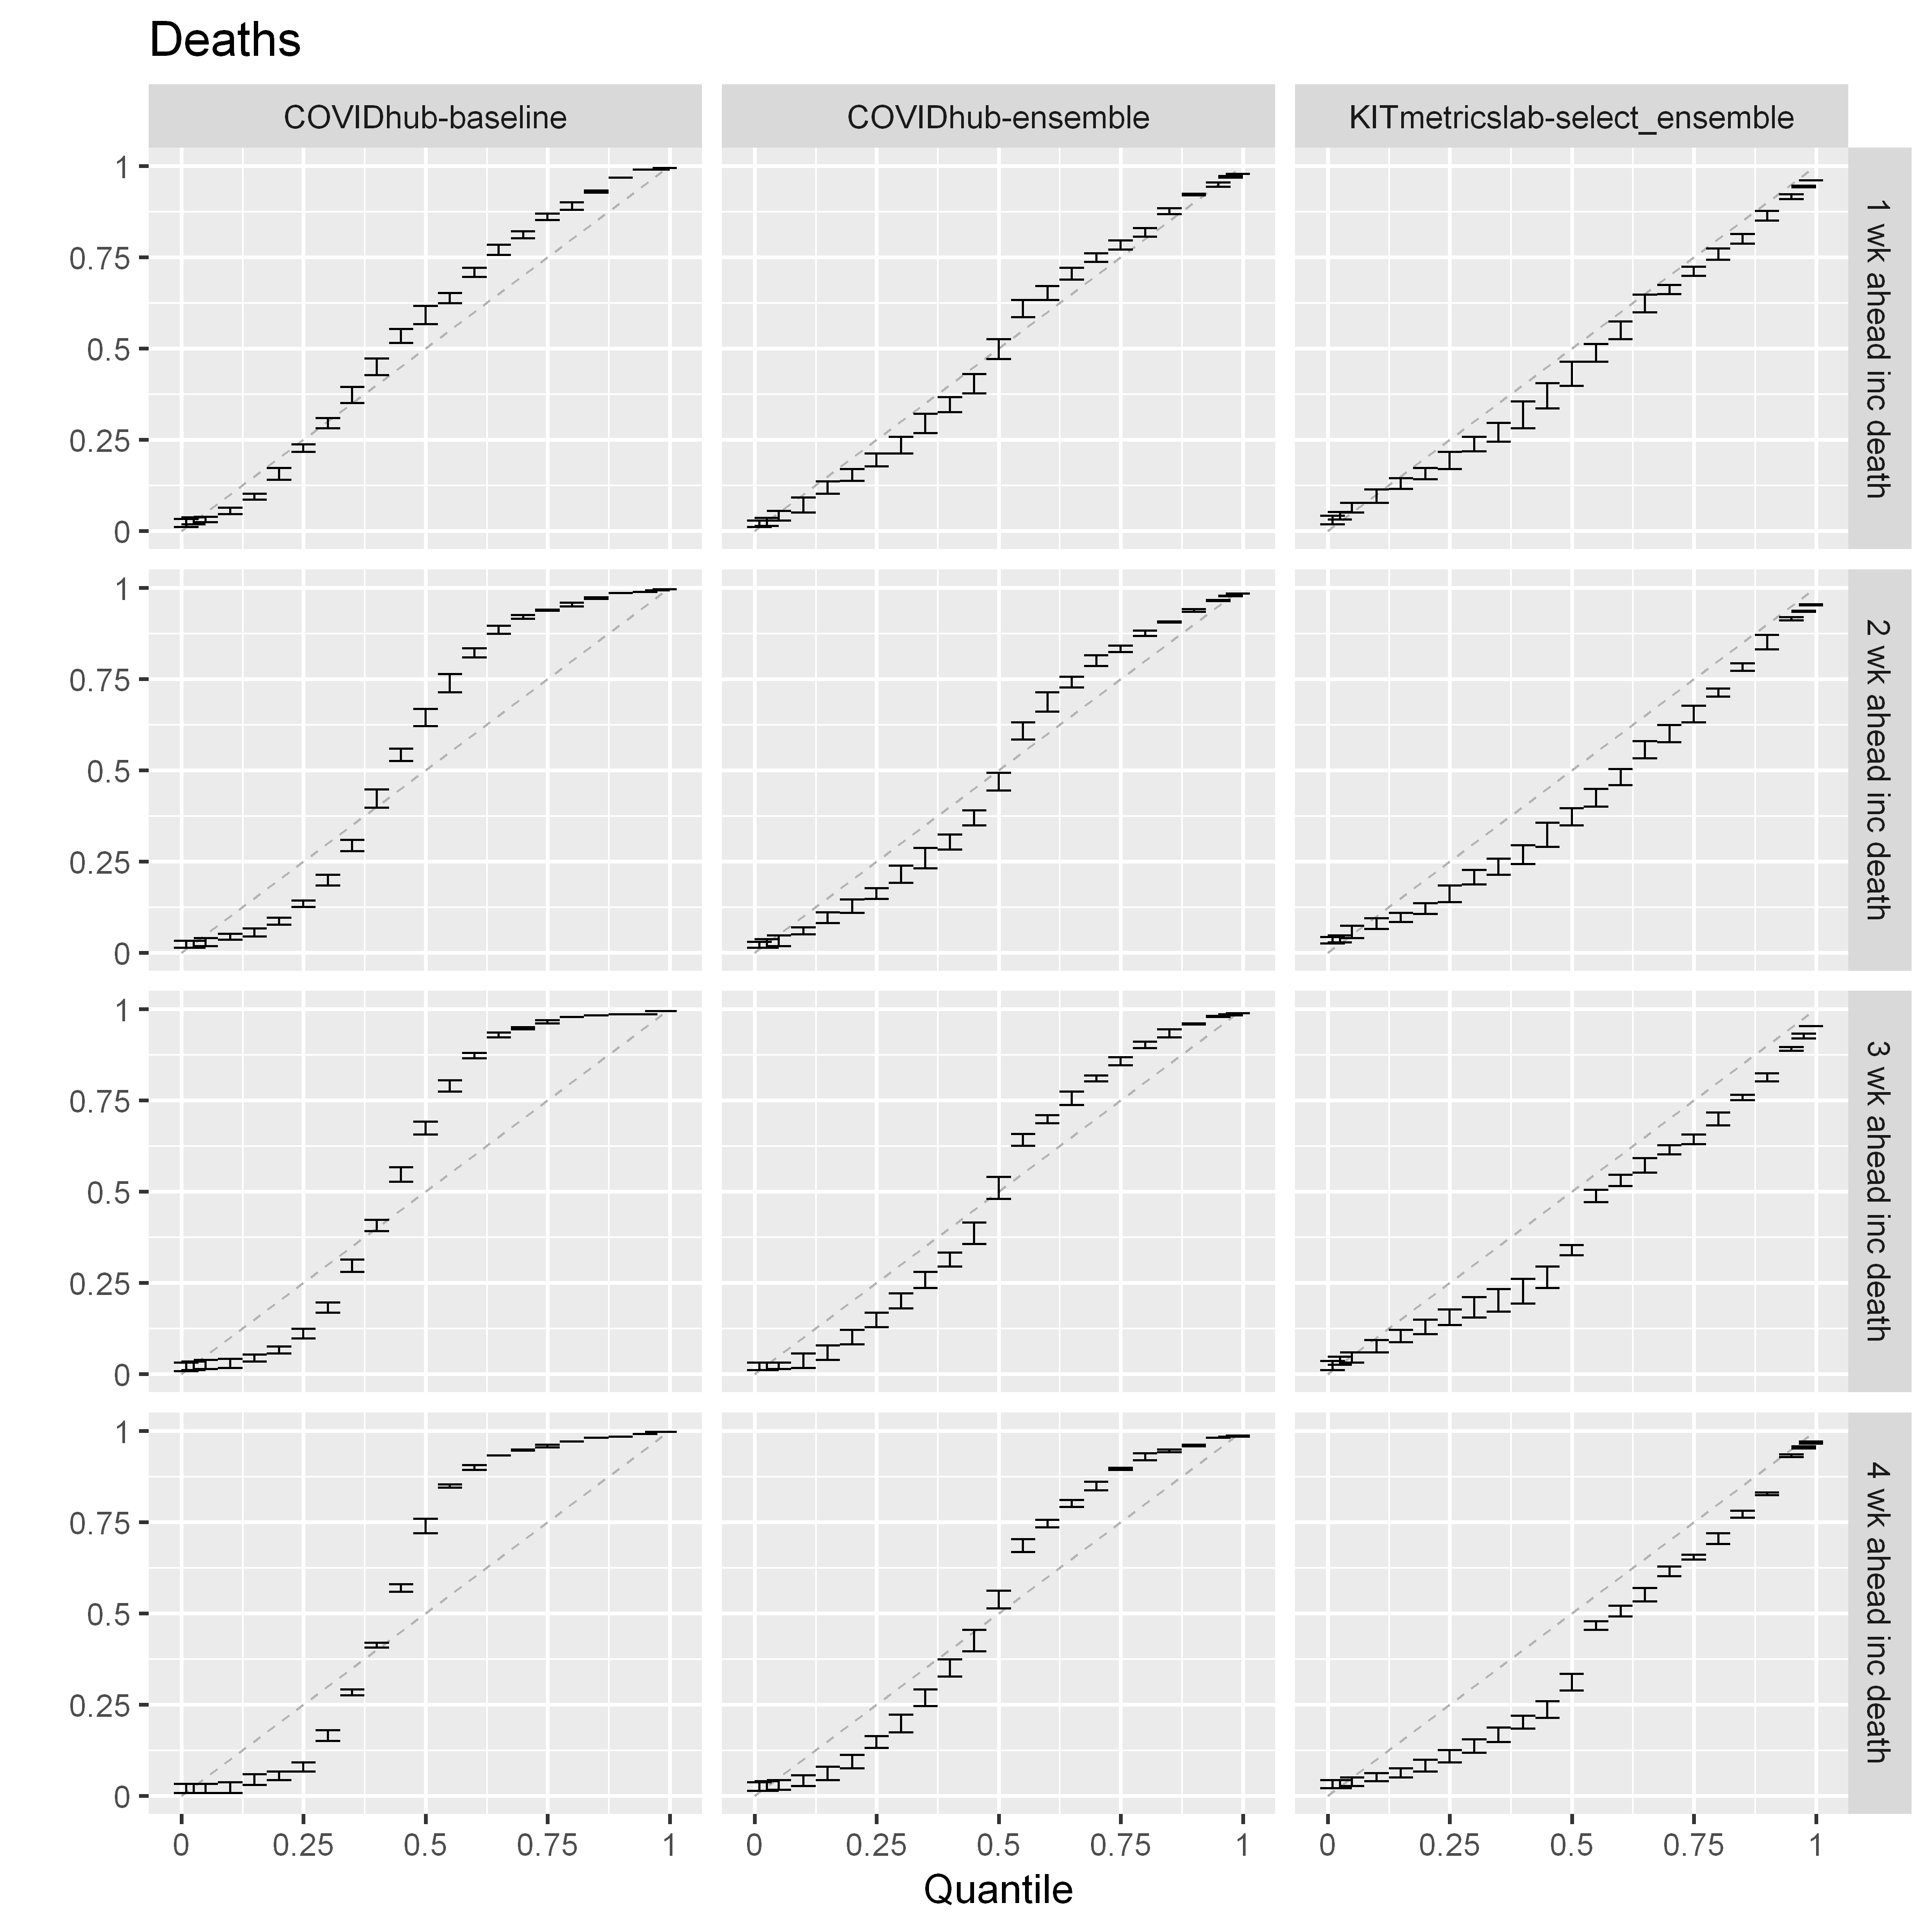

In [20]:
plot_coverage("death")

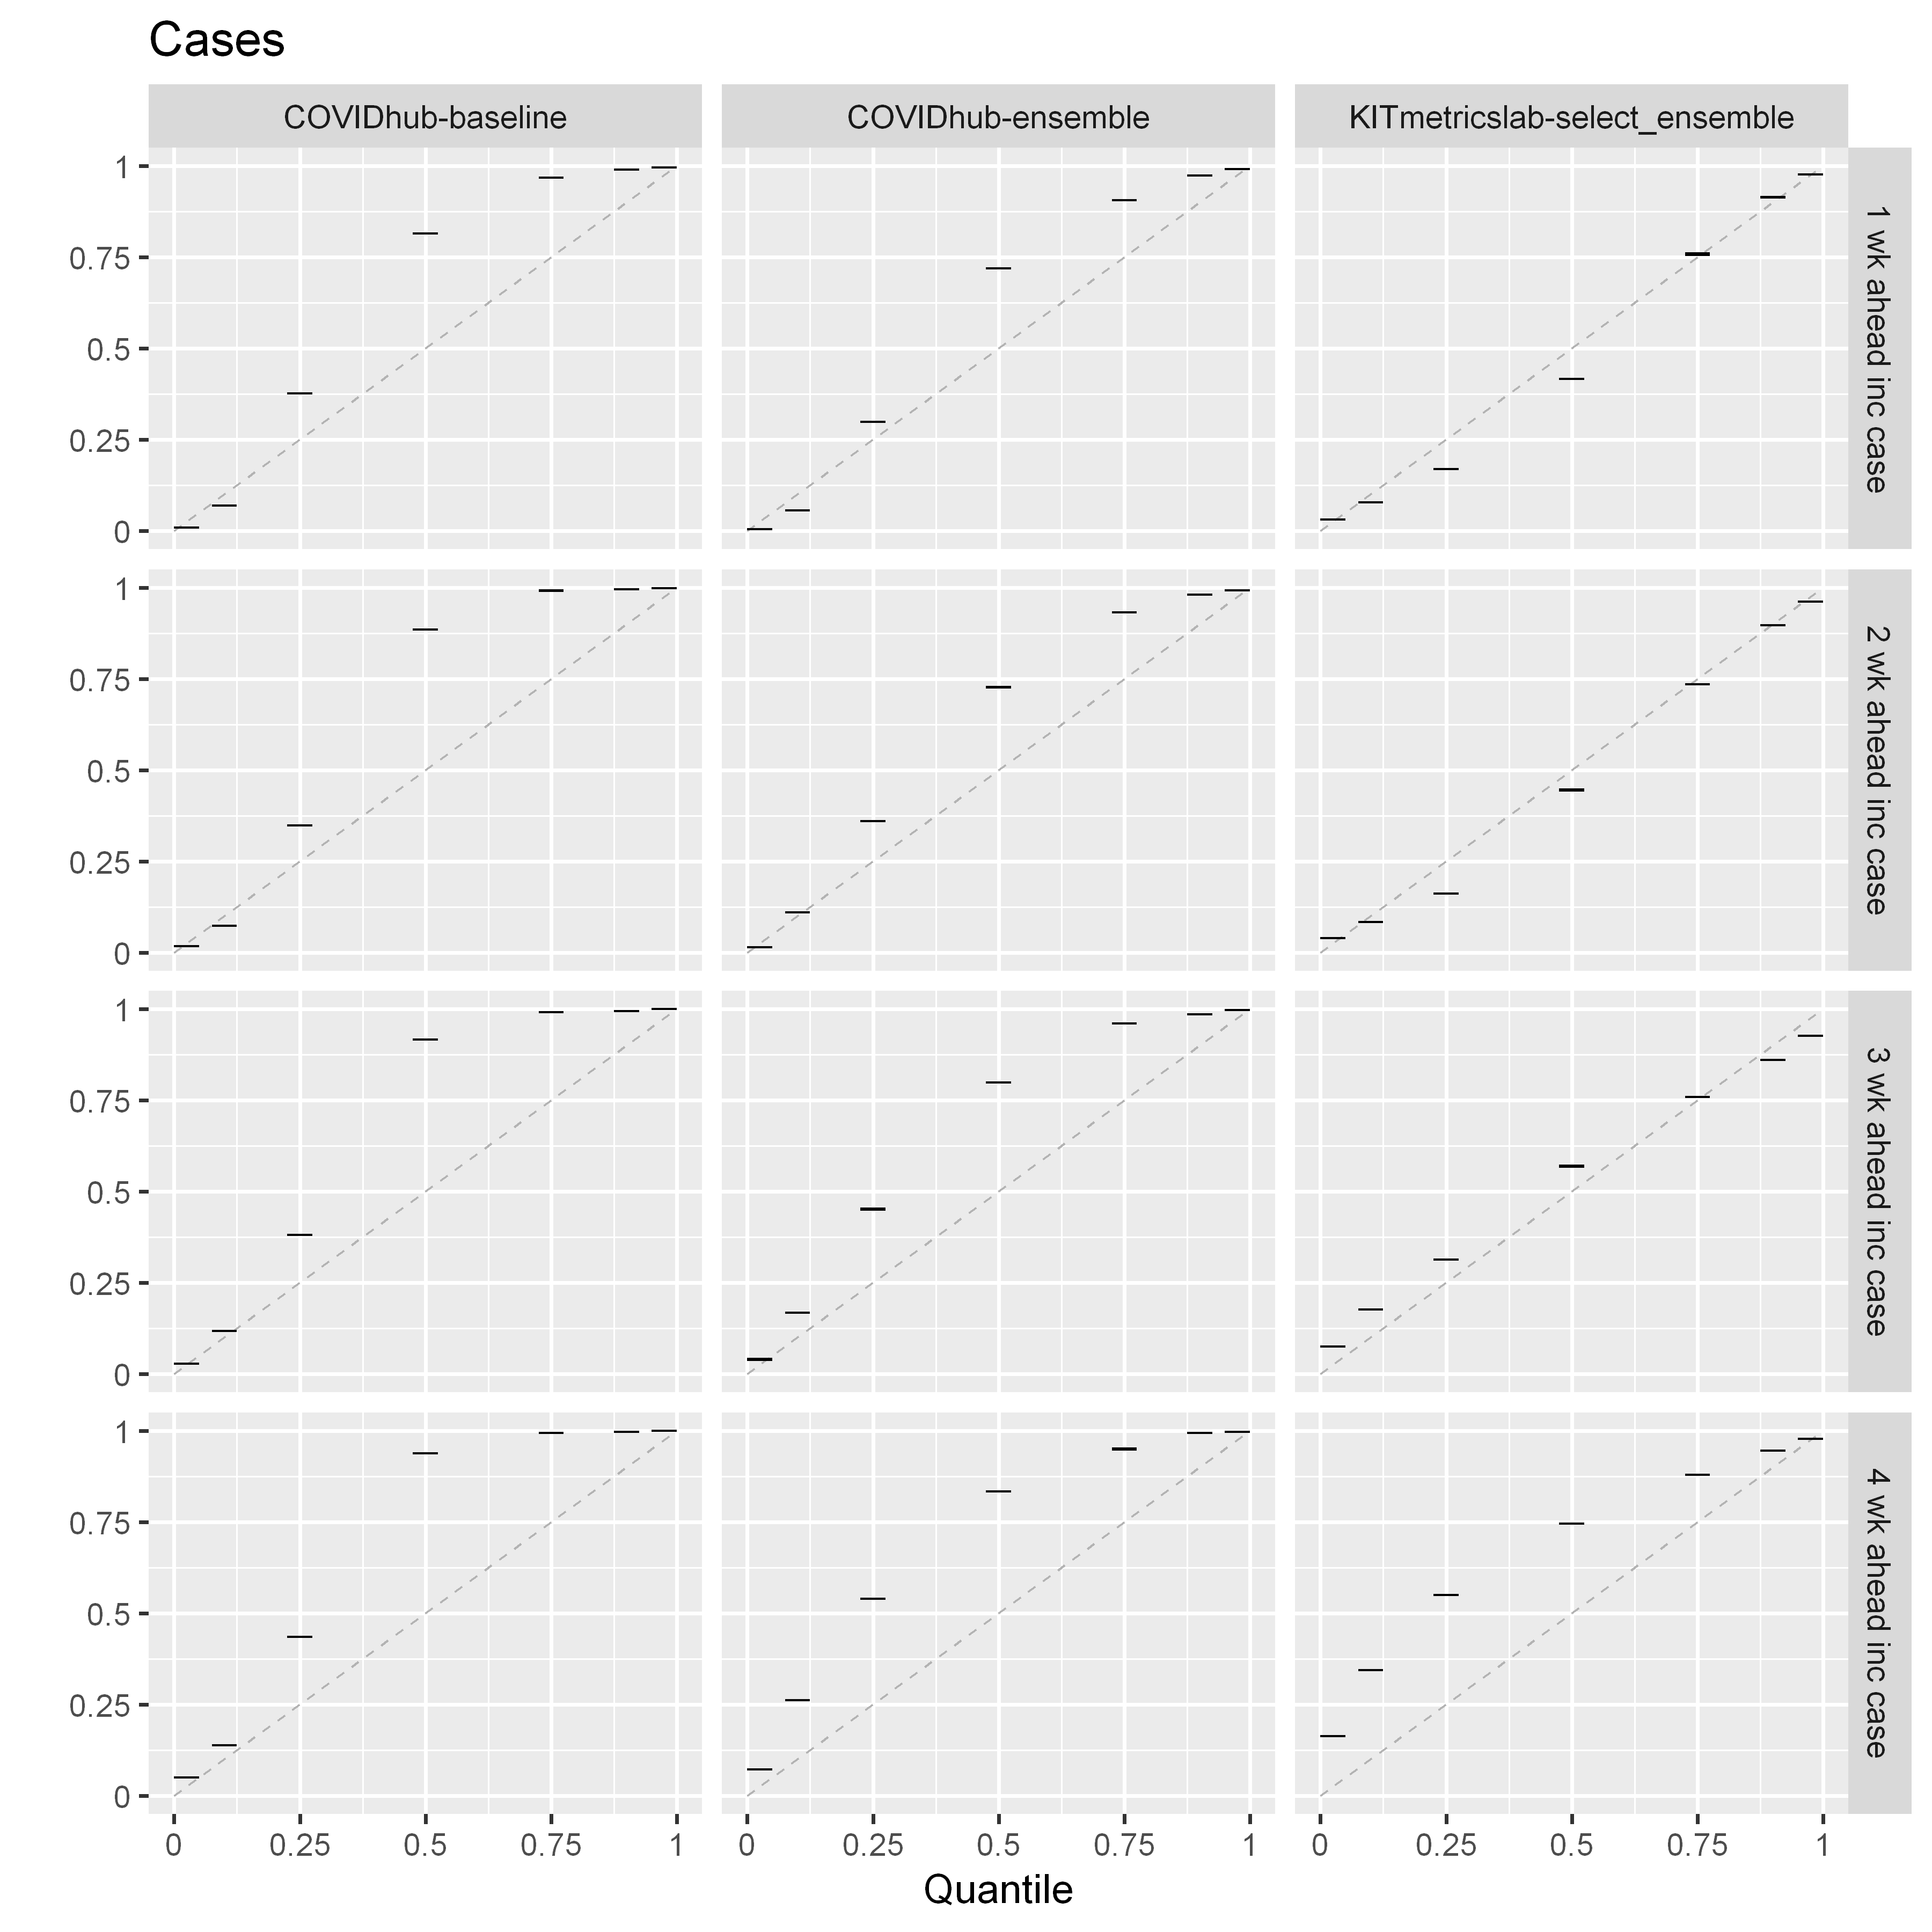

In [21]:
plot_coverage("case")

# Forecasts

Shown are national level median forecasts (white dots) together with 50% and 95% prediciton intervals. The observed values are shown in black.

In [22]:
df <- read_csv("evaluation/2021-06-19_df_processed.csv", col_types = cols())
df <- pivot_wider(df, names_from=quantile, names_prefix="value.", values_from=value)

In [23]:
cols <- colorRampPalette(c("deepskyblue4", "lightgrey"))(2 + 1)[-1]

In [24]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [25]:
df_ens <- df %>%
filter(model == "KITmetricslab-select_ensemble",
      location == "US")

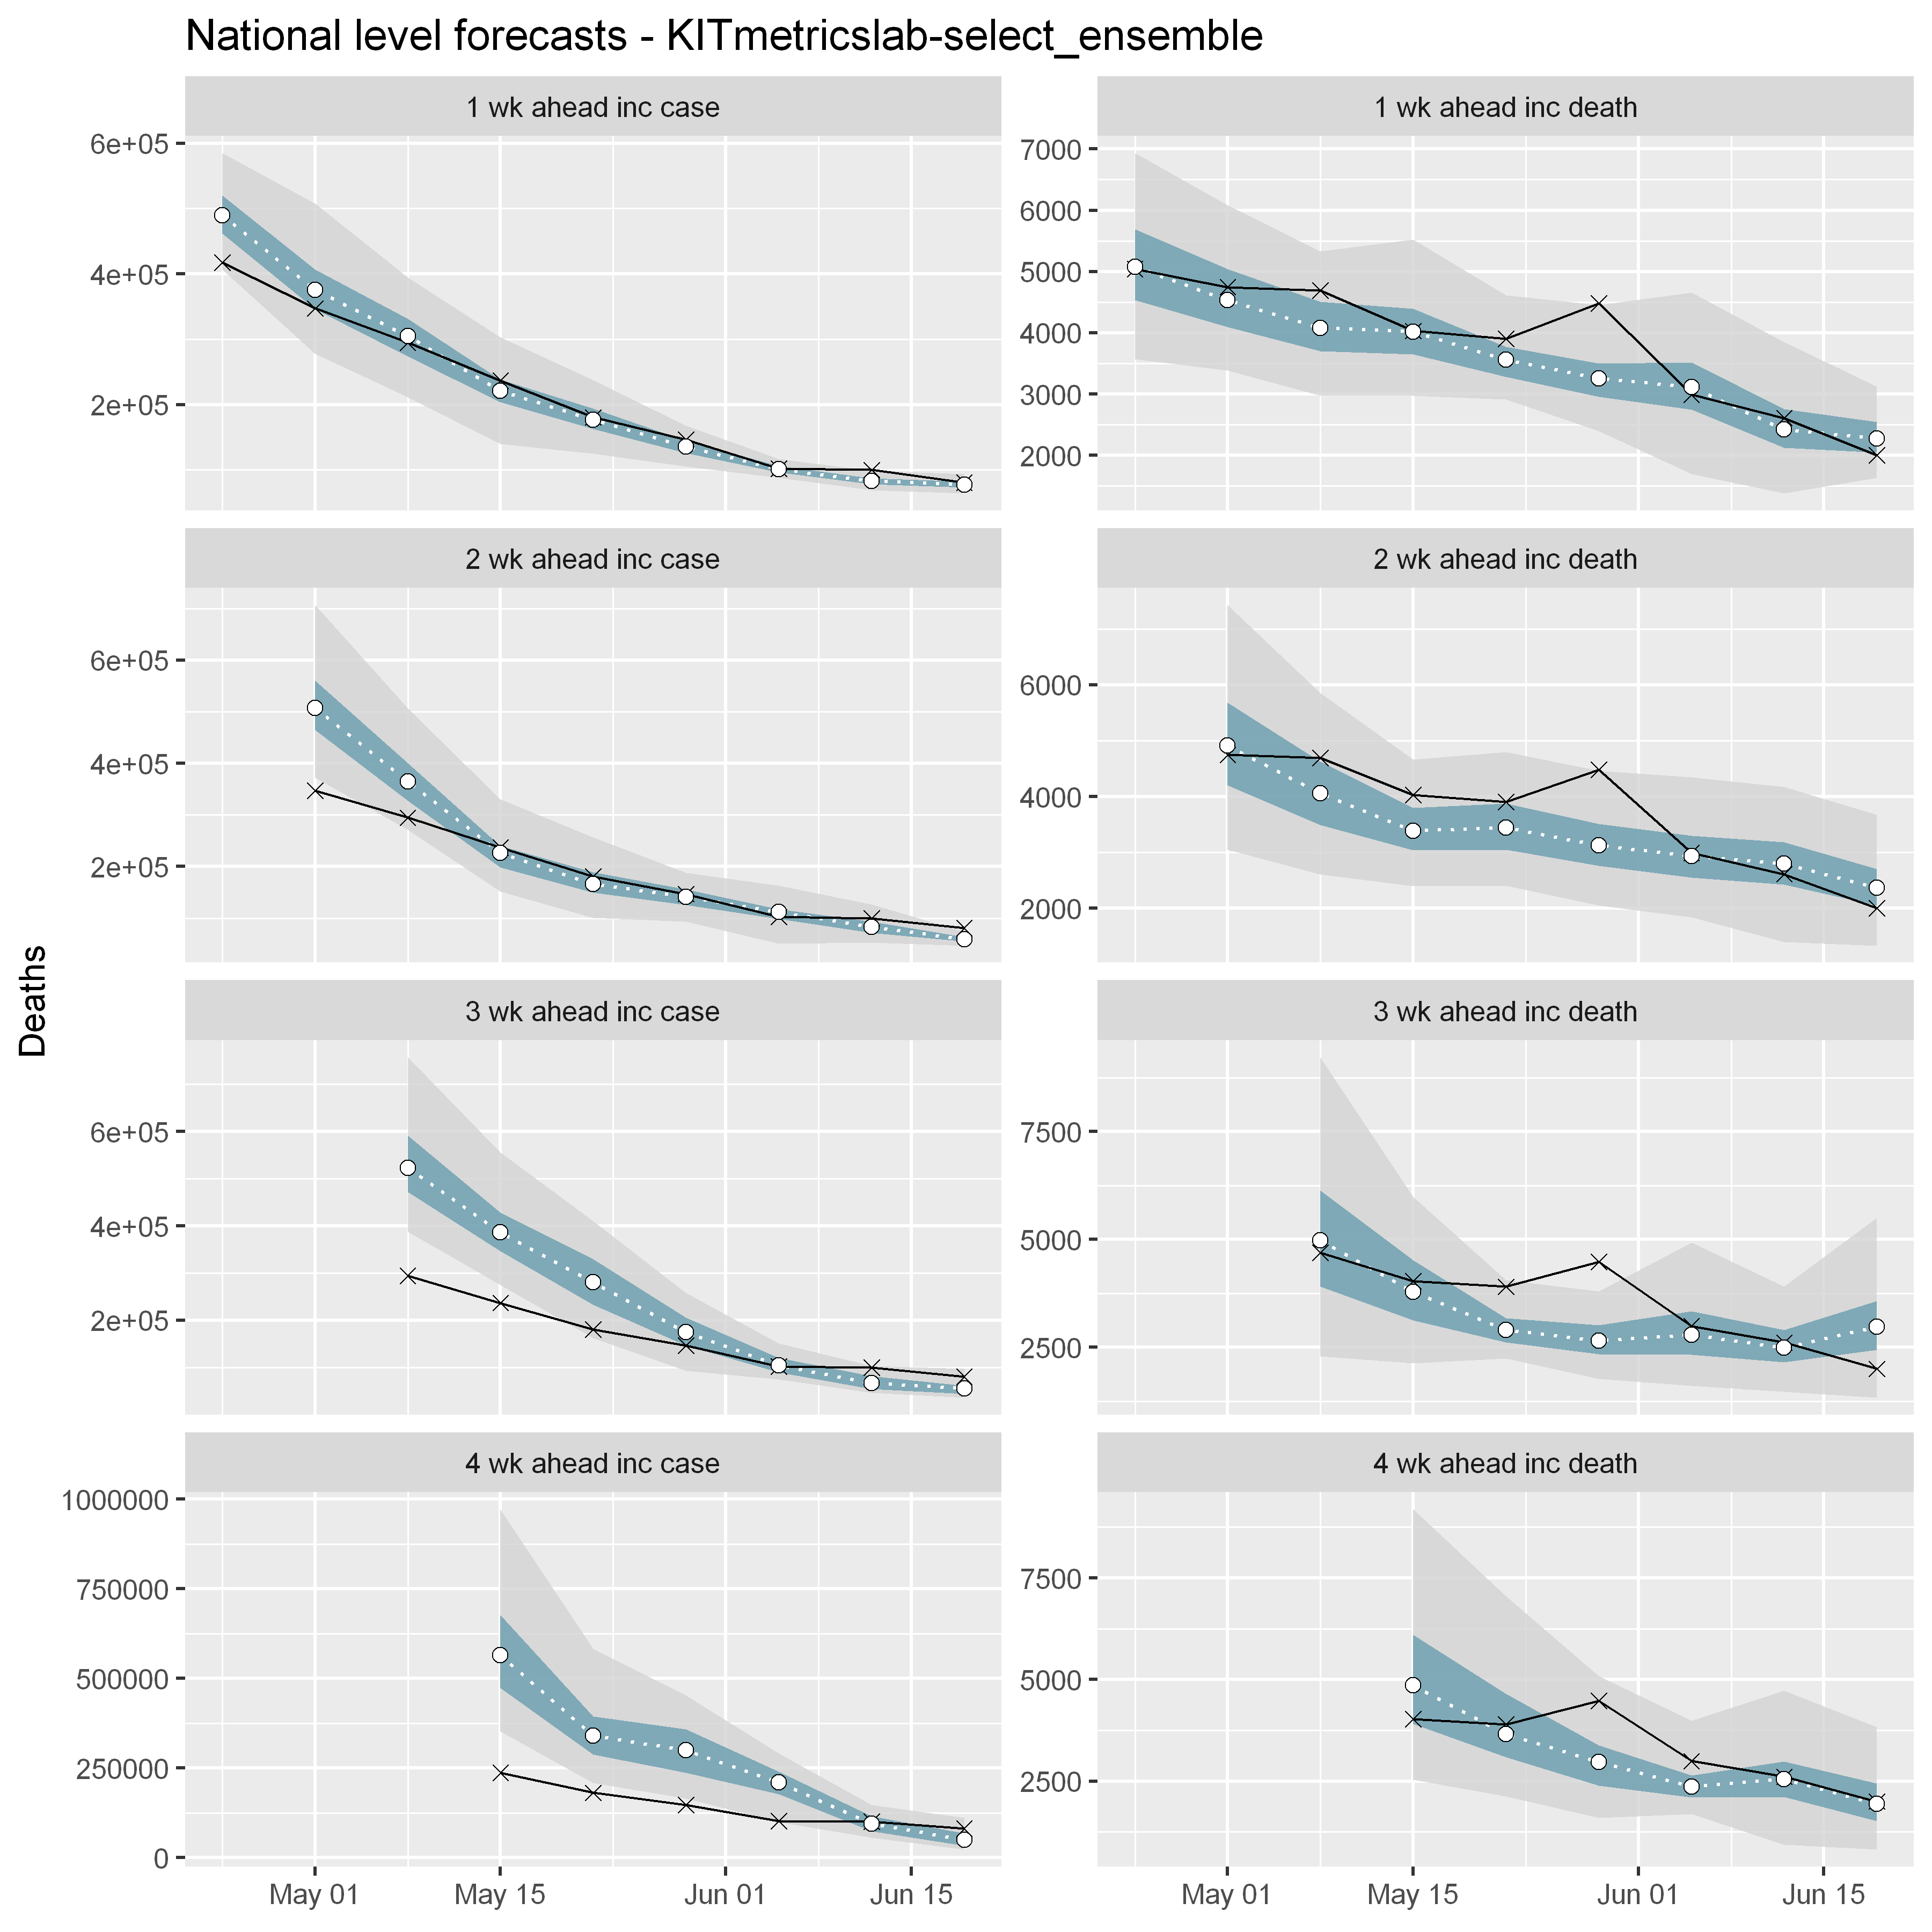

In [26]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - KITmetricslab-select_ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))

In [27]:
df_ens <- df %>%
filter(model == "COVIDhub-ensemble",
      location == "US")

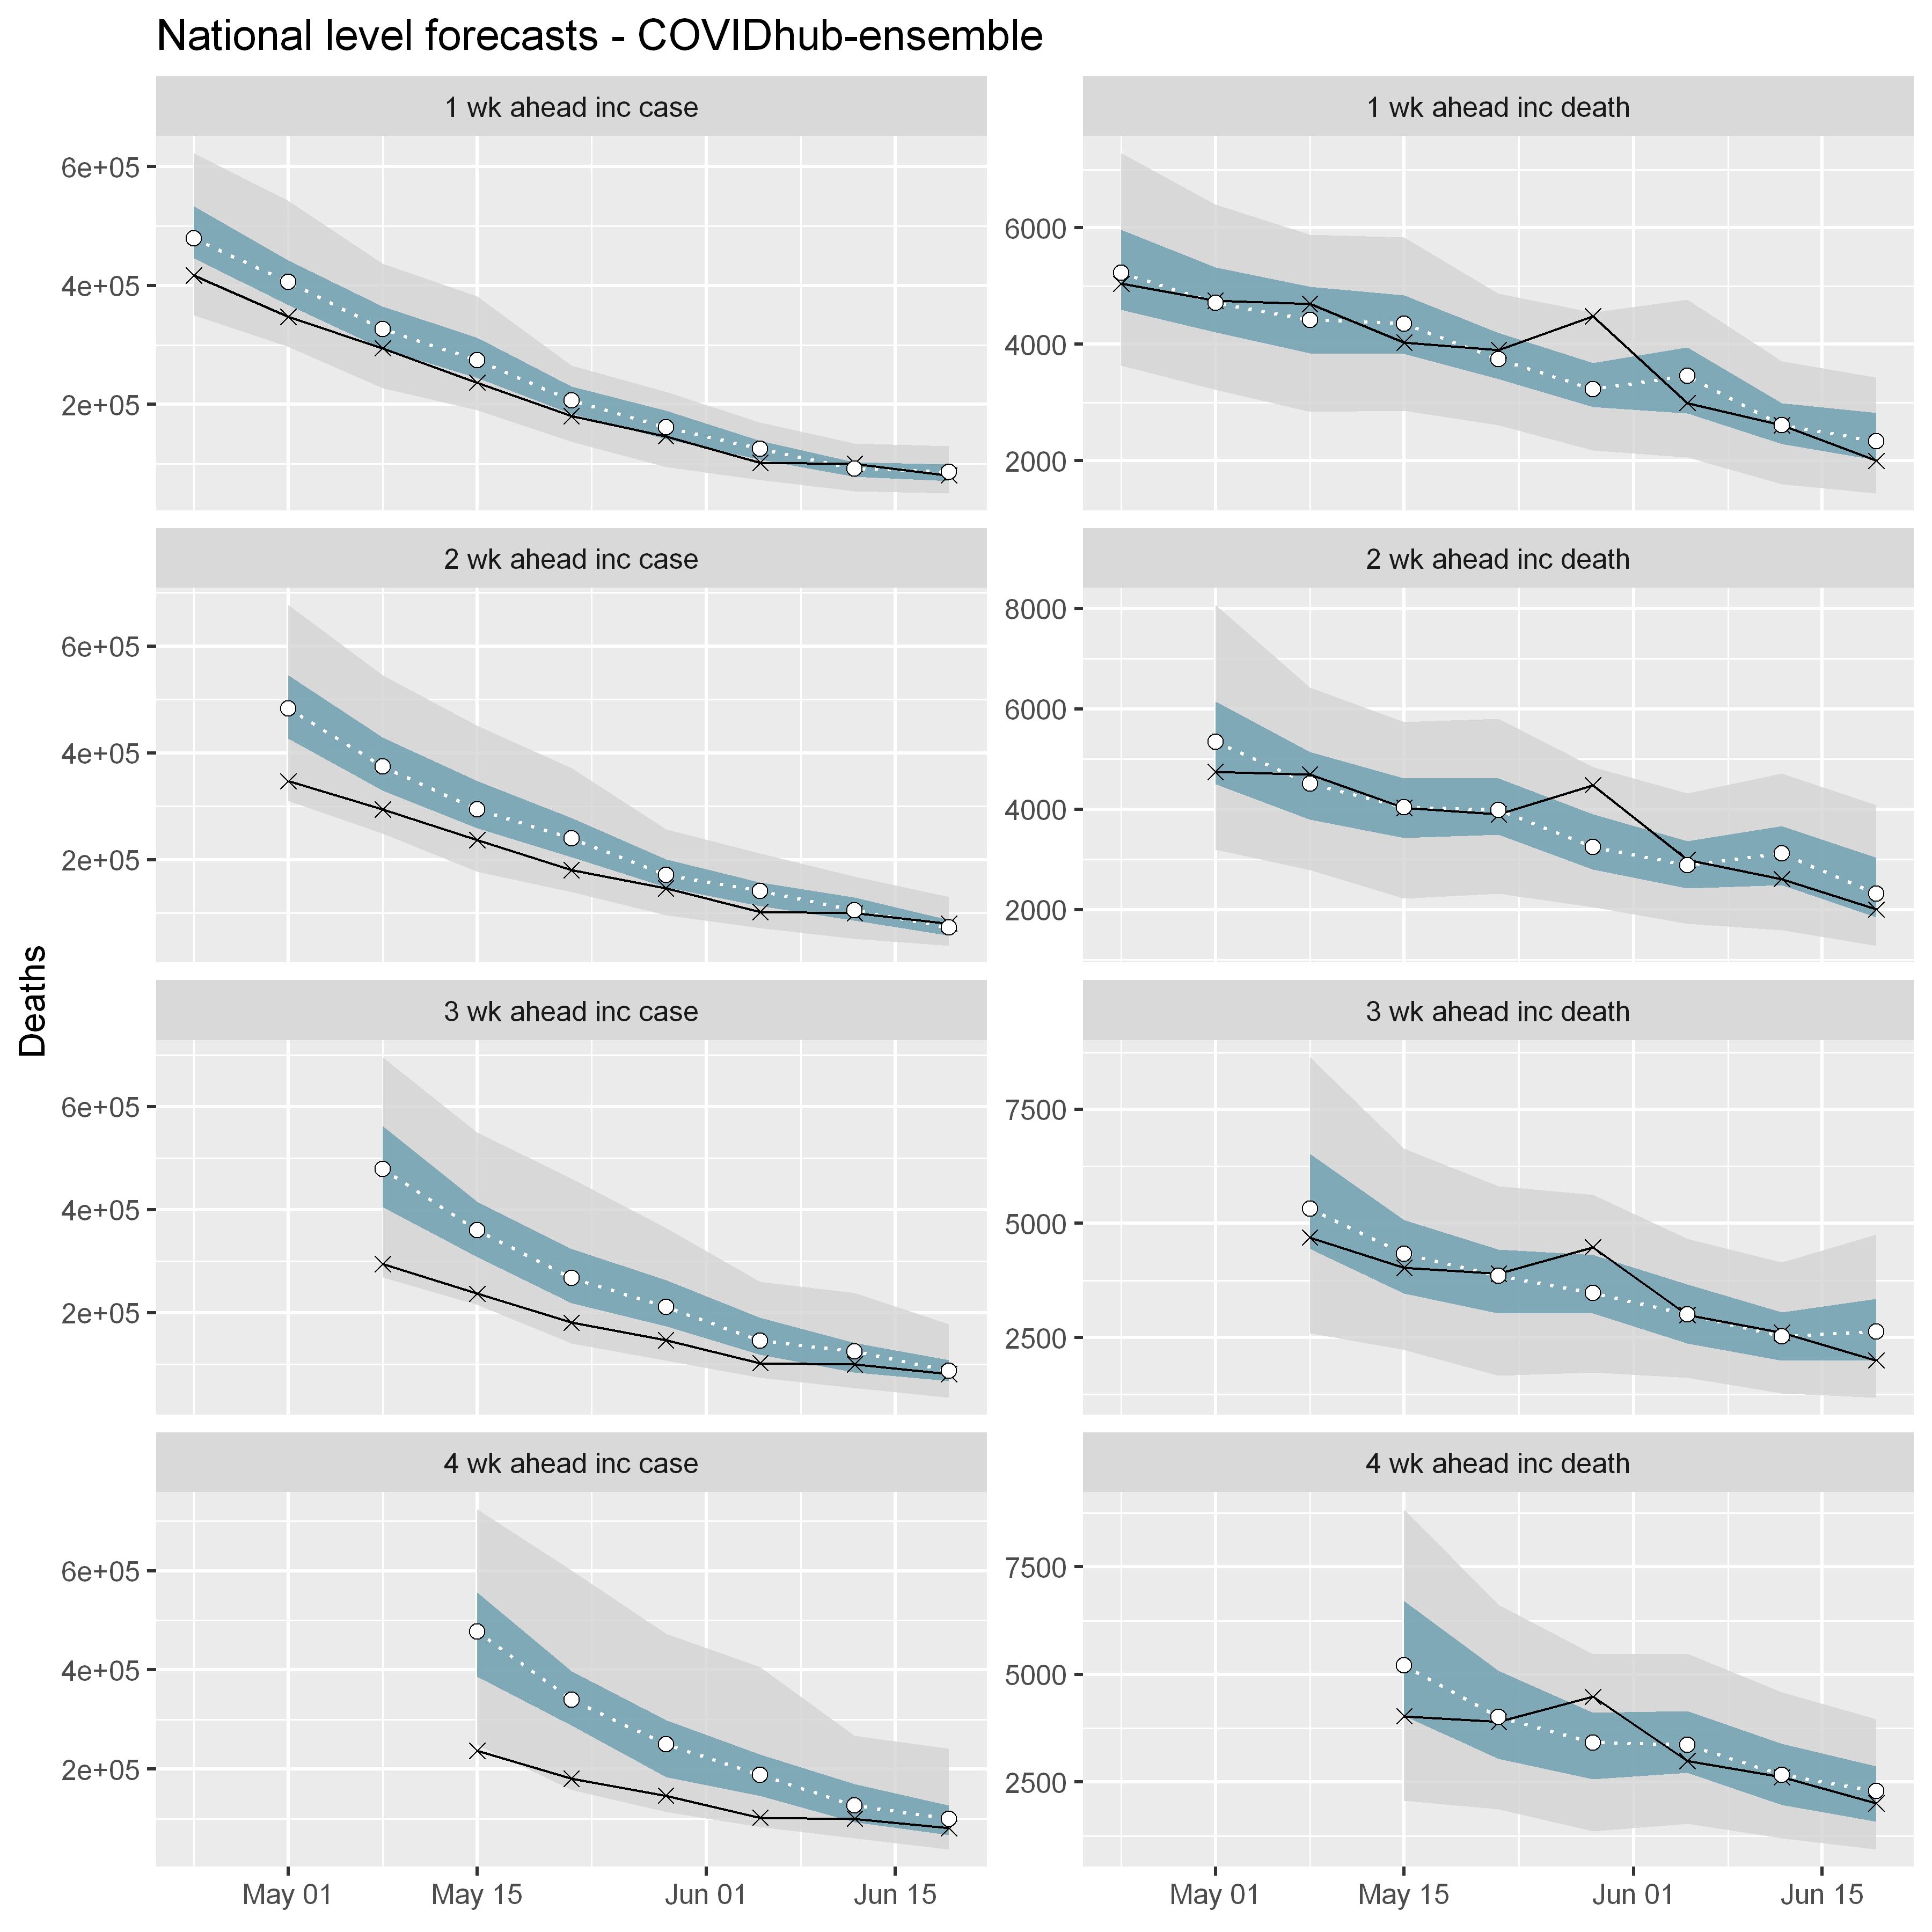

In [28]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - COVIDhub-ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))